In [343]:
%cd ..
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import sys
import seaborn as sns

import functions,loading

sys.path.append(r'D:\github\neurocode\reactivation\assemblies')
import assembly

import nelpy as nel
import nelpy.plotting as npl


import itertools
import numpy as np
import os
import pandas as pd
import nelpy as nel
import multiprocessing
from joblib import Parallel, delayed
import pickle
from scipy import stats
import glob
from scipy.stats import chisquare

from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

d:\github\ripple_heterogeneity


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [3]:
def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat

def get_z_t(st):
    '''
    To increase the temporal resolution beyond the bin-size used to identify the assembly patterns,
    z(t) was obtained by convolving the spike-train of each neuron with a kernel-function
    '''
    # bin to 1ms
    z_t = st.bin(ds=0.001)
    # make binary
    z_t.data[z_t.data > 1] = 1
    # gaussian kernel to match the bin-size used to identify the assembly patterns
    z_t.smooth(sigma=0.025/np.sqrt(12),inplace=True)
    # zscore
    return stats.zscore(z_t.data,axis=1), z_t.bin_centers

def main_analysis(st,ripple_epochs,dt=0.025):

    # binned_st = st.bin(ds=dt)
    # st[~ripple_epochs].bin(ds=dt).data
    (
        patterns_outside_ripples,
        significance_outside_ripples,
        zactmat_outside_ripples
    ) = assembly.runPatterns(st[~ripple_epochs].bin(ds=dt).data)

    (
        patterns_inside_ripples,
        significance_inside_ripples,
        zactmat_inside_ripples
    ) = assembly.runPatterns(st[ripple_epochs].bin(ds=dt).data)

    results = {}
    results['patterns_outside_ripples'] = patterns_outside_ripples
    results['significance_outside_ripples'] = significance_outside_ripples
    results['zactmat_outside_ripples'] = zactmat_outside_ripples

    results['patterns_inside_ripples'] = patterns_inside_ripples
    results['significance_inside_ripples'] = significance_inside_ripples
    results['zactmat_inside_ripples'] = zactmat_inside_ripples

    return results

def session_loop(basepath,save_path):

    save_file = os.path.join(save_path,basepath.replace(os.sep, "_").replace(":", "_")  + '.pkl')
    if os.path.exists(save_file):
        return

    cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

    restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                        ((cell_metrics.brainRegion=="CA1") |
                        (cell_metrics.brainRegion=="rCA1") |
                        (cell_metrics.brainRegion=="lCA1")) &
                        (cell_metrics.bad_unit==False))

    # restrict cell metrics                      
    cell_metrics = cell_metrics[restrict_idx]

    if cell_metrics.shape[0] == 0:
        return
        
    # get ripple epochs
    ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
    try:
        st = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)
    except:
        st = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx][0], fs=fs_dat)

    results = main_analysis(st,ripple_epochs)

    results['UID'] = cell_metrics.UID
    results['basepath'] = basepath
    results['deepSuperficial'] = cell_metrics.deepSuperficial

    # save file
    with open(save_file, 'wb') as f:
        pickle.dump(results, f)

def assembly_run(df,save_path,parallel=True):
    # find sessions to run
    basepaths = pd.unique(df.basepath)

    if not os.path.exists(save_path):
        os.mkdir(save_path)

    if parallel:
        num_cores = multiprocessing.cpu_count()         
        processed_list = Parallel(n_jobs=num_cores)(delayed(session_loop)(basepath,save_path) for basepath in basepaths)
    else:    
        for basepath in basepaths:
            print(basepath)
            session_loop(basepath,save_path)   

In [4]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\cell_assembly'
assembly_run(df,save_path,parallel=True)

In [14]:
sessions = glob.glob(save_path +os.sep+ '*.pkl')

UID = []
deepSuperficial = []
weights = []
membership = []
df = pd.DataFrame()
assembly_n = 0
assembly_ = []
basepath = []
# unique_UID = []
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)

    for pattern in results['patterns_inside_ripples']:
        UID.append(results['UID'])
        # unique_UID.append(np.arange(0,len(results['UID'])))
        deepSuperficial.append(results['deepSuperficial'])
        weights.append(pattern)
        thres = np.mean(pattern) + np.std(pattern)*2
        membership.append(pattern > thres)
        assembly_.append([assembly_n]*len(pattern))
        assembly_n += 1
        basepath.append([results['basepath']]*len(pattern))

df['UID'] = np.hstack(UID)
# df['unique_UID'] = np.hstack(unique_UID)
df['basepath'] = np.hstack(basepath)
df['deepSuperficial'] = np.hstack(deepSuperficial)
df['weights'] = np.hstack(weights)
df['membership'] = np.hstack(membership)
df['assembly_n'] = np.hstack(assembly_)

df

,UID,basepath,deepSuperficial,weights,membership,assembly_n
0,1,Z:\Data\AYAold\AB1\day1,Deep,-0.068668,False,0
1,2,Z:\Data\AYAold\AB1\day1,Superficial,0.025379,False,0
2,9,Z:\Data\AYAold\AB1\day1,Deep,-0.064106,False,0
3,10,Z:\Data\AYAold\AB1\day1,Superficial,0.052817,False,0
4,12,Z:\Data\AYAold\AB1\day1,Deep,-0.157216,False,0
...,...,...,...,...,...,...
51049,112,Z:\Data\ORproject\OR23\day5,Deep,-0.092685,False,964
51050,113,Z:\Data\ORproject\OR23\day5,Deep,-0.012515,False,964
51051,114,Z:\Data\ORproject\OR23\day5,Deep,0.016179,False,964
51052,115,Z:\Data\ORproject\OR23\day5,Superficial,0.025150,False,964


In [181]:
# print('unique units',df.basepath_UID.nunique())

print('n sessions',df.basepath.nunique())
print('n assemblies',df.assembly_n.nunique())
print('')
print('n deep units',(df.deepSuperficial == 'Deep').sum())
print('n sup units',(df.deepSuperficial == 'Superficial').sum())
print('')
print('n deep members',((df.deepSuperficial == 'Deep') & df.membership).sum())
print('n sup members',((df.deepSuperficial == 'Superficial') & df.membership).sum())

n sessions 209
n assemblies 965

n deep units 33910
n sup units 17144

n deep members 960
n sup members 418


In [239]:
# _, p = proportions_ztest(n_deep, current_df.shape[0])
p

5.570410399235511e-276

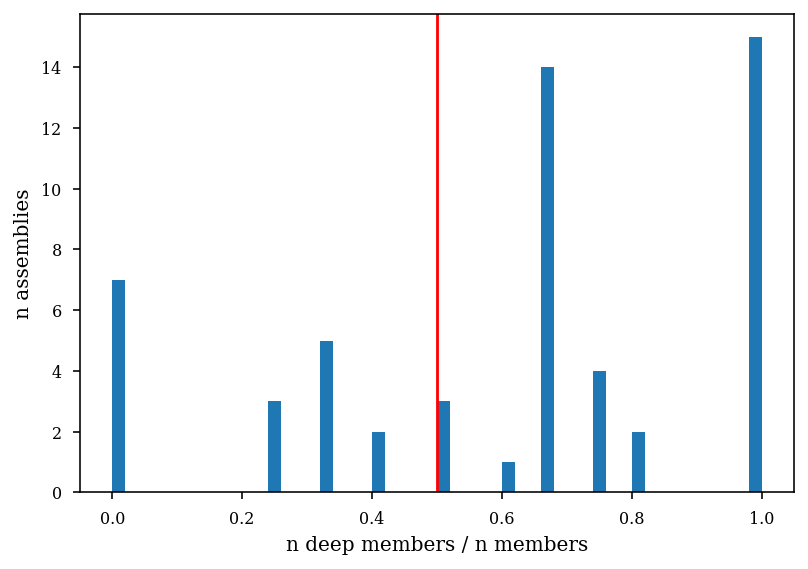

(0.0, 1.0)

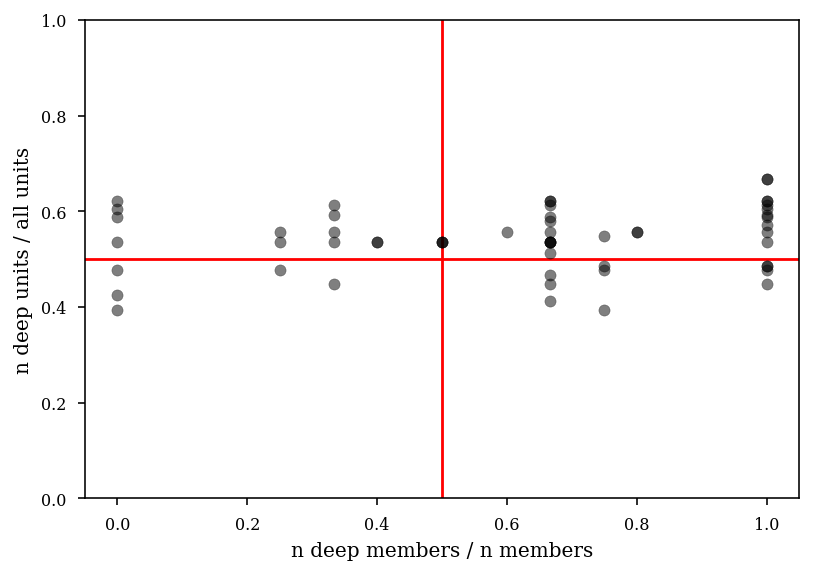

In [240]:
from statsmodels.stats.proportion import proportions_ztest

rel_prop_deep_sup = []
prop_deep = []
basepath = []
n_deeps = []
n_sups = []
assembly_n = []
n_deep_mem = []
n_sup_mem = []

for n_as in df.assembly_n.unique():
    current_df = df[df.assembly_n == n_as]
    n_deep = (current_df.deepSuperficial == "Deep").sum()
    n_sup = (current_df.deepSuperficial == "Superficial").sum()

    _,p = chisquare([n_deep,n_sup])

    if (current_df.membership.sum() > 2) & (p > 0.05) & (n_deep >= 5) & (n_sup >= 5):
        n_deep_mem.append(((current_df.deepSuperficial == "Deep") & (current_df.membership)).sum())
        n_sup_mem.append(((current_df.deepSuperficial == "Superficial") & (current_df.membership)).sum())

        rel_prop_deep_sup.append(n_deep_mem[-1] / (current_df.membership).sum())

        prop_deep.append(((current_df.deepSuperficial == "Deep")).sum() / current_df.shape[0])
        basepath.append(current_df.basepath.unique())
        assembly_n.append(n_as)
        n_deeps.append(n_deep)
        n_sups.append(n_sup)

basepath = np.hstack(basepath)

prop_df = pd.DataFrame()
prop_df['basepath'] = basepath
prop_df['rel_prop_deep_sup'] = rel_prop_deep_sup
prop_df['assembly_n'] = assembly_n
prop_df['n_deep'] = n_deeps
prop_df['n_sup'] = n_sups
prop_df['n_deep_mem'] = n_deep_mem
prop_df['n_sup_mem'] = n_sup_mem


plt.hist(rel_prop_deep_sup,50)
# binned,_ = np.histogram(rel_prop_deep_sup,bins=np.arange(0,1.1,10))
# plt.plot(binned)
plt.xlabel('n deep members / n members')
plt.ylabel('n assemblies')
plt.axvline(.5,color='r')
plt.show()

plt.figure()
plt.scatter(rel_prop_deep_sup,prop_deep,alpha=.5,color='k')
plt.ylabel('n deep units / all units')
plt.xlabel('n deep members / n members')
plt.axvline(.5,color='r',zorder=-1000)
plt.axhline(.5,color='r',zorder=-1000)
# plt.xlim(0,1)
plt.ylim(0,1)


In [190]:
prop_df.head()

,basepath,rel_prop_deep_sup,assembly_n,n_deep,n_sup,n_deep_mem,n_sup_mem
0,Z:\Data\AYAold\AB1\day1,1.000000,2,35,22,3,0
1,Z:\Data\AYAold\AB1\day1,0.333333,4,35,22,1,2
2,Z:\Data\AYAold\AB1\day1,0.666667,5,35,22,2,1
3,Z:\Data\AYAold\AB3\AB3_38_41,1.000000,6,44,38,4,0
4,Z:\Data\AYAold\AB3\AB3_38_41,0.666667,7,44,38,2,1


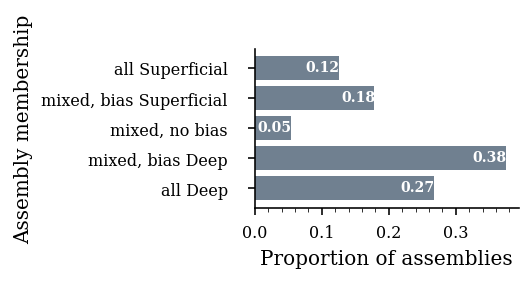

In [255]:
# rel_prop_deep_sup = np.array(prop_df.rel_prop_deep_sup)

all_sup = prop_df.rel_prop_deep_sup == 0
all_deep = prop_df.rel_prop_deep_sup == 1
mixed_bias_sup = (prop_df.rel_prop_deep_sup > 0) & (prop_df.rel_prop_deep_sup < .5)
mixed_bias_deep = (prop_df.rel_prop_deep_sup > .5) & (prop_df.rel_prop_deep_sup < 1)
mixed_no_bias = prop_df.rel_prop_deep_sup == .5

# plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(1,1)), edgecolor='k')

labels = ['all Superficial','mixed, bias Superficial','mixed, no bias','mixed, bias Deep', 'all Deep']
counts = [all_sup.sum(),mixed_bias_sup.sum(),mixed_no_bias.sum(),mixed_bias_deep.sum(),all_deep.sum()]

 
fig, ax = plt.subplots(figsize=functions.set_size('thesis', fraction=.4, subplots=(1,1)), edgecolor='k')
 
# Horizontal Bar Plot
ax.barh(labels,counts / sum(counts),color='slategrey')
 
# Remove axes splines
for s in ['top', 'right']:
    ax.spines[s].set_visible(False)
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()-.05, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 7, fontweight ='bold',
             color ='w',zorder=100)

ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.set_xlabel('Proportion of assemblies') 
ax.set_ylabel('Assembly membership')             

plt.savefig(os.path.join(fig_save_path,'assembly_unit_id.svg'),dpi=300,bbox_inches='tight')

In [15]:
# prob_deep = []
# prob_sup = []
rel_prop_deep_sup = []
for n_as in df.assembly_n.unique():
    current_df = df[df.assembly_n == n_as]
    if (current_df.membership.sum() > 1) & (current_df.deepSuperficial.nunique() > 1):

        n_deep = ((current_df.deepSuperficial == "Deep") & (current_df.membership)).sum()
        n_sup = ((current_df.deepSuperficial == "Superficial") & (current_df.membership)).sum()
        rel_prop_deep_sup.append((n_sup - n_deep) / (n_deep + n_sup))
   
        # prob_deep.append(((current_df.deepSuperficial == "Deep") & (current_df.membership)).sum() / (current_df.membership).sum())
        # prob_sup.append(((current_df.deepSuperficial == "Superficial") & (current_df.membership)).sum() / (current_df.membership).sum())


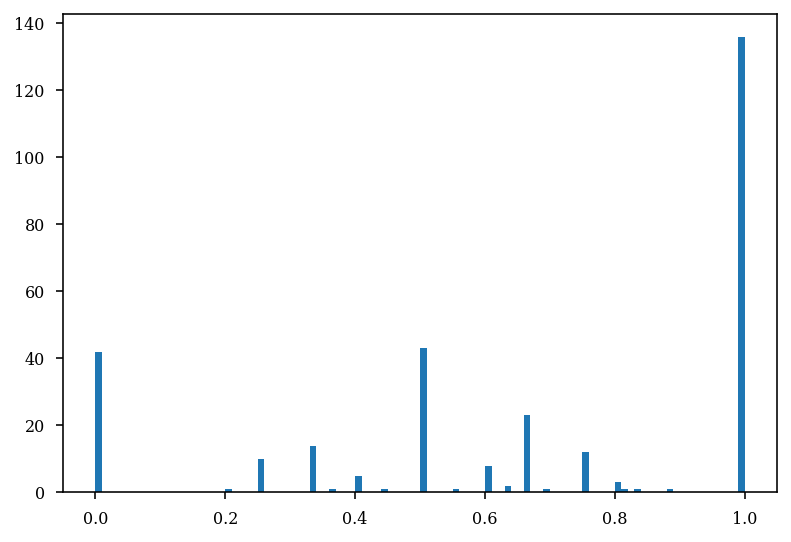

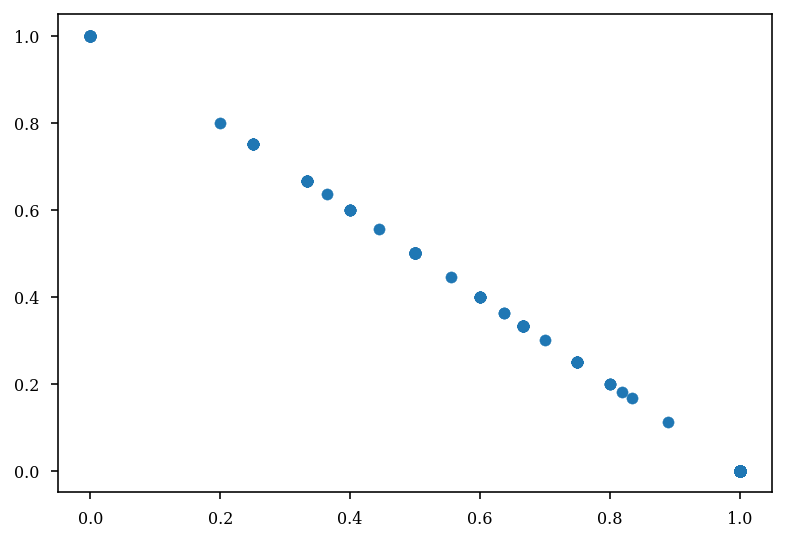

In [116]:
plt.hist(prob_deep,100)
plt.show()

# plt.hist(prob_sup,100)
# plt.show()

plt.scatter(prob_deep,prob_sup)

In [103]:
shuff_out = []
for i_shuff in range(1000):
    labels = df['deepSuperficial'].values.copy()
    random.shuffle(labels)
    for n_as in df.assembly_n.unique():
        current_labels = labels[df.assembly_n == n_as]
        shuff_out.append((current_labels[(df[df.assembly_n == n_as].membership == True)] == "Deep").sum() / (current_labels == "Deep").sum())


C:\Users\Cornell\AppData\Local\Temp/ipykernel_17752/2526867844.py:7: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\Cornell\AppData\Local\Temp/ipykernel_17752/2526867844.py:7: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\Cornell\AppData\Local\Temp/ipykernel_17752/2526867844.py:7: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\Cornell\AppData\Local\Temp/ipykernel_17752/2526867844.py:7: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\Cornell\AppData\Local\Temp/ipykernel_17752/2526867844.py:7: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\Cornell\AppData\Local\Temp/ipykernel_17752/2526867844.py:7: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\Cornell\AppData\Local\Temp/ipykernel_17752/2526867844.py:7: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\Cornell\AppData\Local\Temp/ipykernel_17752/2526867844.py:7: RuntimeWarning: invalid value encountered 

KeyboardInterrupt: 

In [66]:
((df[df.assembly_n == 2].deepSuperficial == 'Deep') & (df[df.assembly_n == 2].membership)).sum()

print((df.deepSuperficial == "Deep").sum())
print((df.deepSuperficial == "Superficial").sum())


print(((df.deepSuperficial == "Deep") & (df.membership)).sum())
print(((df.deepSuperficial == "Superficial") & (df.membership)).sum())


34323
17427
857
436


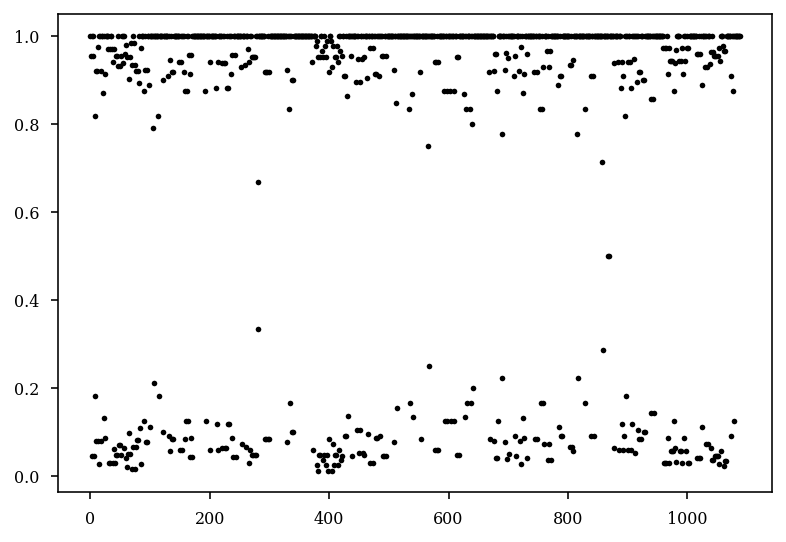

In [101]:
# from scipy.stats.contingency import margins
# print(df.groupby('deepSuperficial').membership.value_counts())
# print(df.groupby('deepSuperficial').membership.count())

# print(df.groupby('deepSuperficial').membership.value_counts() / df.groupby('deepSuperficial').membership.count())

# df.groupby(['deepSuperficial','assembly_n']).membership.count()
group_by_df = df.groupby(['deepSuperficial','assembly_n']).membership.value_counts() / df.groupby(['deepSuperficial','assembly_n']).membership.count()
# group_by_df['membership']
# df.groupby(['deepSuperficial','assembly_n']).membership.apply(lambda g: g.value_counts()/len(g))
# plt.plot(group_by_df['Deep'].values,'.k')
plt.plot(group_by_df['Superficial'].values,'.k')


<AxesSubplot:xlabel='assembly_n', ylabel='weights'>

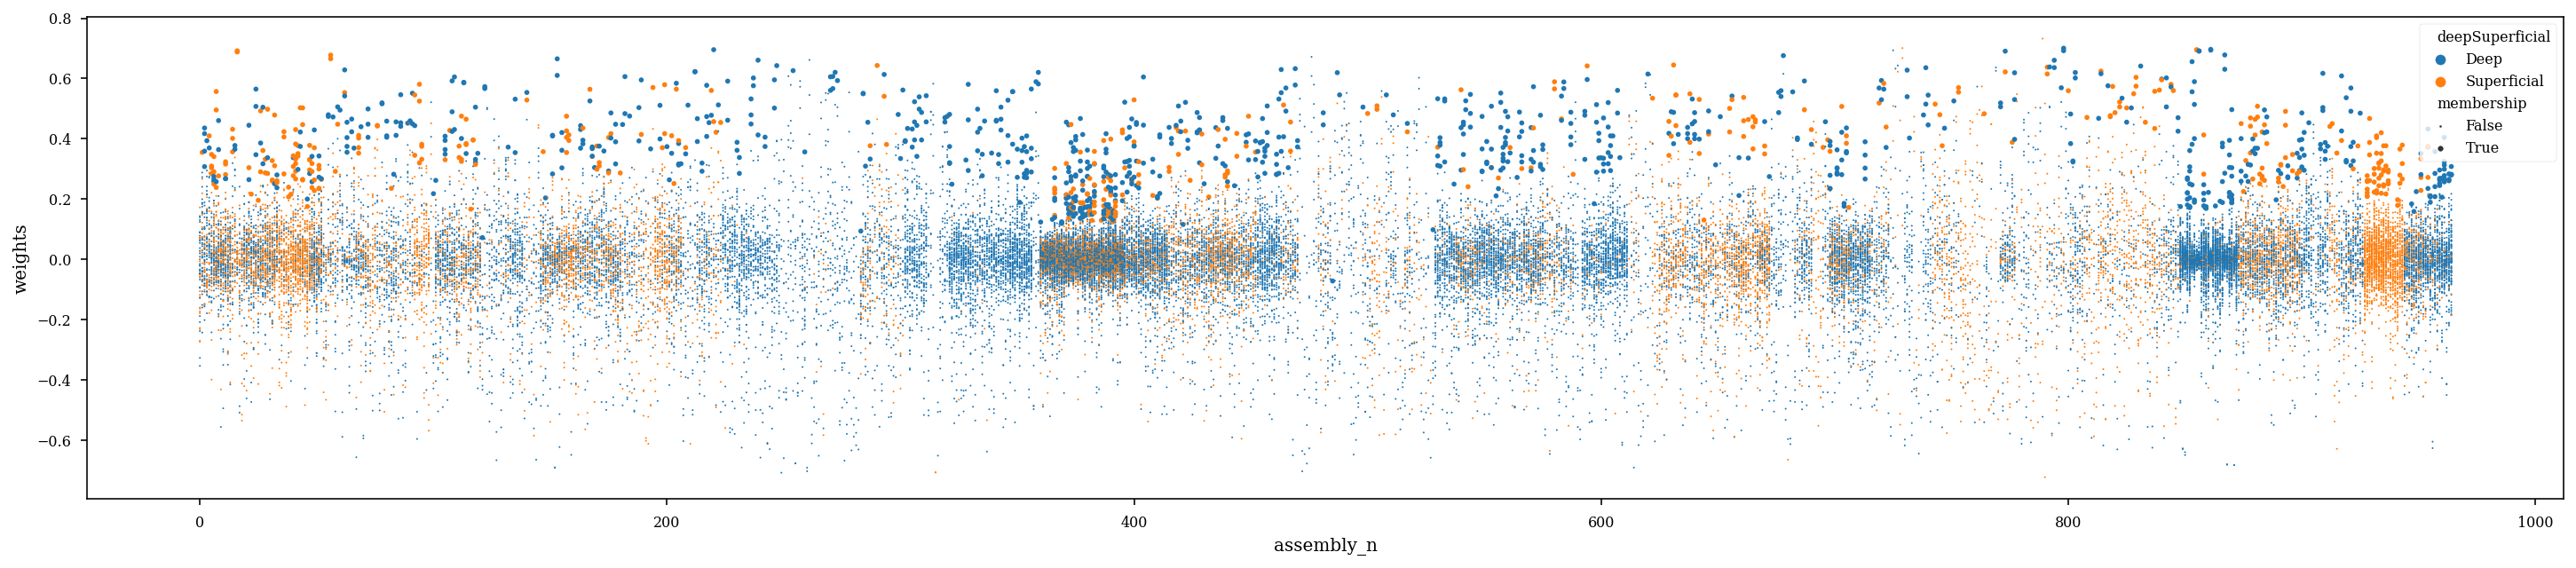

In [63]:
# plt.plot(df.assembly_n,df.weights)
plt.figure(figsize=(25,5))
sns.scatterplot(x="assembly_n", y="weights",
                hue="deepSuperficial", size="membership",
                sizes=(8, 1), linewidth=0,
                data=df)

# plt.xlim(0,100)                

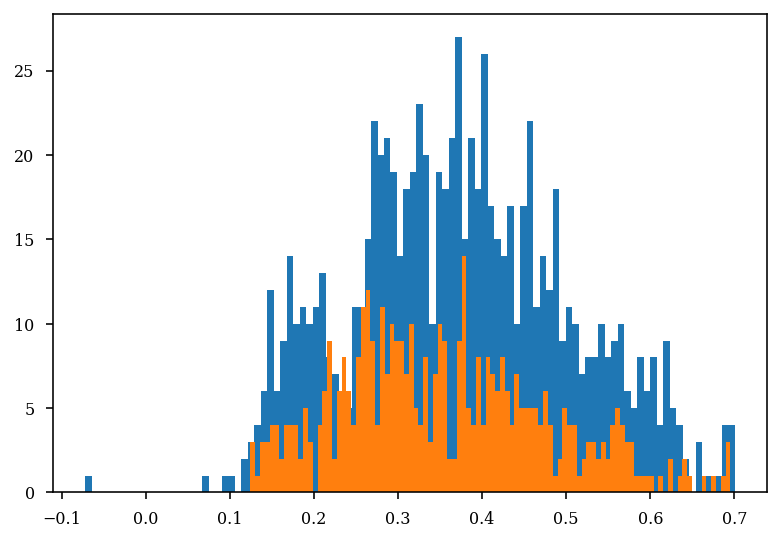

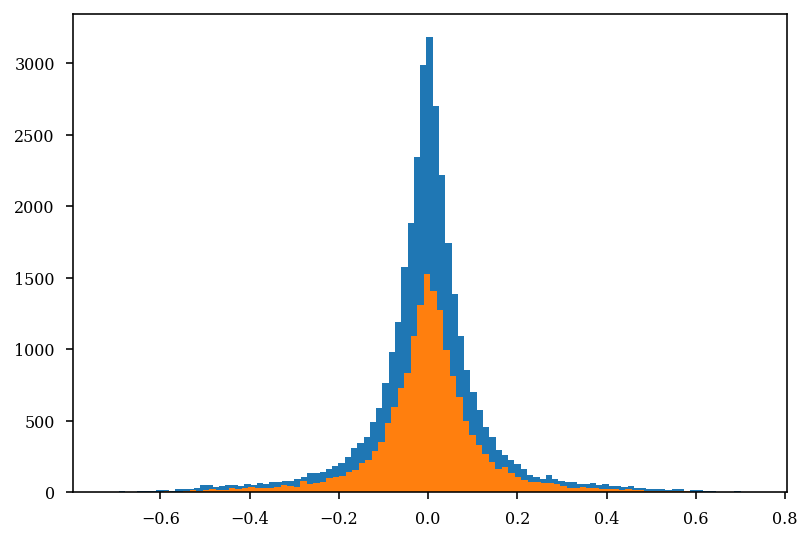

In [8]:

# sns.histplot(
#     df,
#     x="weights", hue="membership",
#     multiple="stack",
#     palette="light:m_r",
#     edgecolor=".3",
#     linewidth=.5
# )

plt.hist(df.weights[(df.membership == True) & (df.deepSuperficial == "Deep")],100)
plt.hist(df.weights[(df.membership == True) & (df.deepSuperficial == "Superficial")],100)
plt.show()

plt.hist(df.weights[(df.deepSuperficial == "Deep")],100)
plt.hist(df.weights[(df.deepSuperficial == "Superficial")],100)
plt.show()

In [35]:
def pvalue(shuff_dist,score):
        # DOI: 10.2202/1544-6115.1585
        return (sum(np.abs(shuff_dist) > np.abs(score)) + 1) /(len(shuff_dist) + 1)

def mixing_index(values):
    if isinstance(values, float):
        if values > 0.5:
            return (values * -1) + 1
    else:
        values[values > .5] = (values[values > .5] * -1) + 1
    return values

obs = []
shuff_out = []

for session in sessions:

    with open(session, 'rb') as f:
        results = pickle.load(f)

    assmbl = results['patterns_inside_ripples']
    if len(assmbl) == 0:
        continue
    thres = np.mean(assmbl,axis=1) + np.std(assmbl,axis=1)*2
    for idx in np.array((assmbl.T)>thres).T:
        if (idx.sum() == 0) | (idx.sum() == 1):
            continue
        
        labels = results['deepSuperficial'].values.copy()
        # print(labels[idx],sum(labels[idx] == "Deep") / idx.sum())
        obs.append(sum(labels[idx] == "Deep") / idx.sum())
        # obs = mixing_index(obs)

        for i_shuff in range(1000):
            labels = results['deepSuperficial'].values.copy()
            random.shuffle(labels)
            shuff_out.append(sum(labels[idx] == "Deep") / idx.sum())
        # shuff_out = mixing_index(np.array(shuff_out))   

        # plt.figure()
        # plt.hist(shuff_out)  
        # plt.title(pvalue(shuff_out,obs))
        # plt.axvline(obs,color='r')  


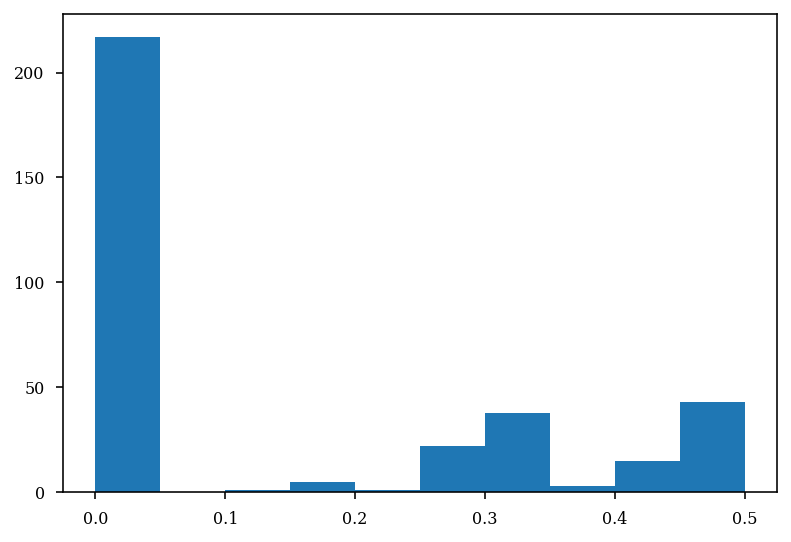

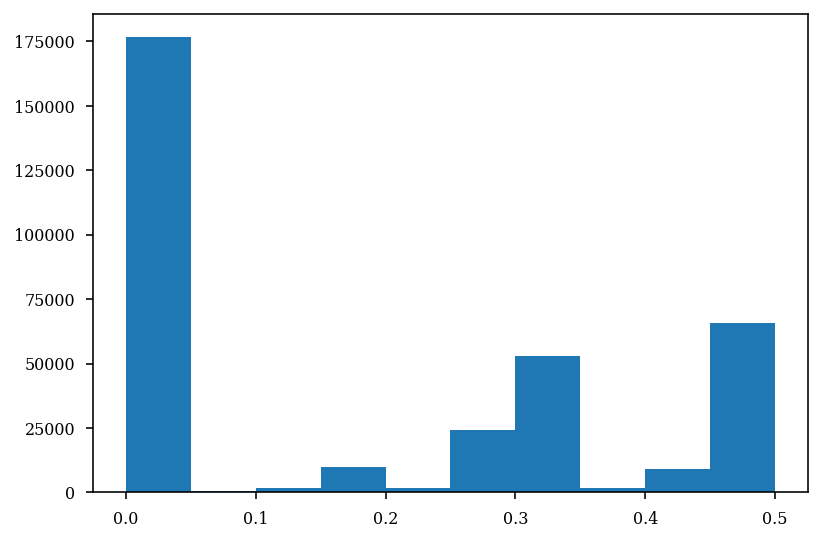

In [44]:
plt.hist(mixing_index(np.array(obs)))
plt.show()
plt.hist(mixing_index(np.array(shuff_out)))
plt.show()

In [9]:
import random

# assmbl = results['patterns_inside_ripples']
# thres = np.mean(assmbl,axis=1) + np.std(assmbl,axis=1)*2

# for idx in np.array((assmbl.T)>thres).T:
#     sum(results['deepSuperficial'][idx].values == "Deep") / idx.sum()

shuff_out = []
obs = []
for session in sessions:
    with open(session, 'rb') as f:
        results = pickle.load(f)

    assmbl = results['patterns_inside_ripples']
    if len(assmbl) == 0:
        continue
    thres = np.mean(assmbl,axis=1) + np.std(assmbl,axis=1)*2

    # labels = results['deepSuperficial'].values.copy()

    obs.append(sum(labels[idx] == "Deep") / idx.sum())

    for i_shuff in range(1000):
        for idx in np.array((assmbl.T)>thres).T:
            if (idx.sum() == 0) | (idx.sum() == 1):
                continue
            labels = results['deepSuperficial'].values.copy()
            random.shuffle(labels)

            shuff_out.append(sum(labels[idx] == "Deep") / idx.sum())
shuff_out = np.hstack(shuff_out)


KeyboardInterrupt: 

In [99]:
shuff_out[shuff_out > .5] = (shuff_out[shuff_out > .5] *-1) + 1

In [22]:
assmbl = results['patterns_inside_ripples']

thres = np.mean(assmbl,axis=1) + np.std(assmbl,axis=1)*2
# plt.imshow((assmbl.T))
# plt.show()
# plt.imshow((assmbl.T)>thres)
for idx in np.array((assmbl.T)>thres).T:
    print(results['deepSuperficial'][idx].values)

[]
['Superficial']
['Deep' 'Deep' 'Deep' 'Deep']
['Deep']
['Superficial' 'Deep']
['Superficial' 'Superficial' 'Superficial' 'Superficial']


In [58]:
# np.argsort(results['deepSuperficial'])
sort_idx = np.argsort(results['deepSuperficial'])
# sort_idx
# results['deepSuperficial'] = results['deepSuperficial'].iloc[sort_idx]
patterns = results['patterns_inside_ripples']

patterns = [pat[sort_idx] for pat in patterns]
# np.array(patterns)
# results['patterns_inside_ripples'][sort_idx]

In [418]:
basepath = 'Z:\Data\AYAold\AB1\day1'
cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")) &
                    (cell_metrics.bad_unit == False))

# restrict cell metrics                      
cell_metrics = cell_metrics[restrict_idx]

ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)
# behavioral_epochs = nel.EpochArray([np.array([data['epochs'].startTime,
#                                                 data['epochs'].stopTime]).T])

filename = glob.glob(os.path.join(basepath,'*.lfp'))[0]
nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)

rip_ch = ripples.ripple_channel.unique()[0]
for sh in shank_to_channel:
    if np.any(shank_to_channel[sh] == rip_ch):
        shank = sh
        break

channel_idx = np.where(shank_to_channel[shank] == rip_ch)[0][0]

lfp,ts = loading.loadLFP(filename, n_channels=nChannels, channel=shank_to_channel[shank], frequency=fs, precision='int16')
lfp_obj = nel.AnalogSignalArray(data=lfp.T,fs=fs)


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.


In [427]:
session = 'Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\cell_assembly_v1\\Z__Data_AYAold_AB1_day1.pkl'
with open(session, 'rb') as f:
    results = pickle.load(f)

z_mat,ts = get_z_t(st_unit)
assemblyAct = assembly.computeAssemblyActivity(results['patterns_inside_ripples'], z_mat)
assembly_act = nel.AnalogSignalArray(data=assemblyAct,timestamps=ts,fs=1000)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.


In [428]:
# st_unit.get_event_firing_order()
# rip = 9
n_deep = []
n_sup = []

for rip in ripple_epochs:
    idx = st_unit[rip].n_events > 0
    if type(idx) != type(True):
        n_deep.append(sum(cell_metrics.deepSuperficial[idx] == 'Deep'))
        n_sup.append(sum(cell_metrics.deepSuperficial[idx] == 'Superficial'))
    else:
        n_deep.append(np.nan)
        n_sup.append(np.nan)

In [318]:
# n_supn_sup == 0
np.argsort((np.array(n_deep)-np.array(n_sup)))[:20]
# print([n_deep/n_sup])

# print(n_deep[587],n_sup[587])

array([ 508,  156, 1358, 1138, 1109,  858,   69,  361,  404,  894,  341,
        912,  705, 1320,   31,  637,  781, 1414,  492, 1158], dtype=int64)

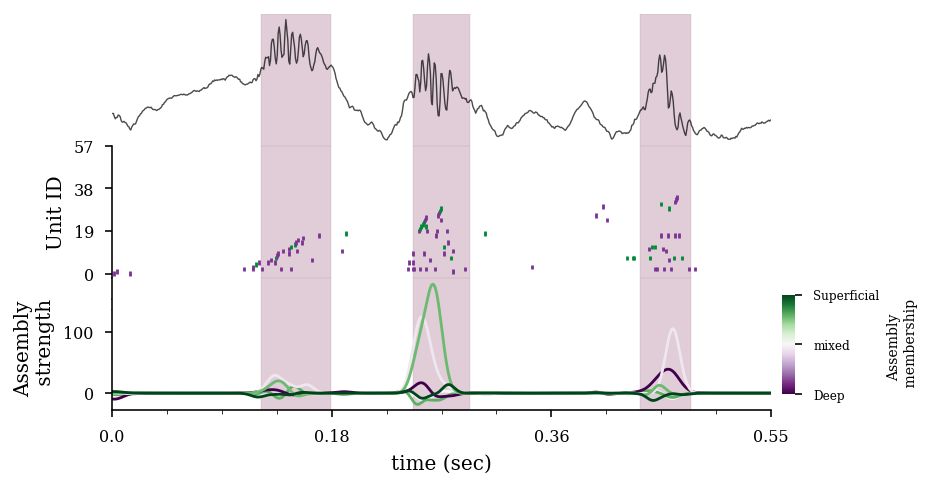

In [548]:
from neurodsp.filt import filter_signal
import warnings
warnings.filterwarnings("ignore")

fig, axs = plt.subplots(3,1, figsize=functions.set_size('thesis', fraction=1, subplots=(1.5,1.5)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0.2)
axs = axs.ravel()

# rip = 9
rip = 1358
rip = 71

window = .5
plotting_epoch = nel.EpochArray([np.array([ripple_epochs[rip].start-window/2,ripple_epochs[rip].stop+window/2]).T])

# Define a frequency range to filter the data
f_range = (100, 250)
# Bandpass filter the data, across the band of interest
# sig_filt = filter_signal(lfp_obj[plotting_epoch].data[channel_idx], fs, 'bandpass', f_range)
axs[0].plot(lfp_obj[plotting_epoch]._abscissa_vals,lfp_obj[plotting_epoch].data[channel_idx],
            color='k',alpha=.7,linewidth=.7,label='ripple bandpass filtered')

# sort by deepSuperficial
colors1 = np.array(['#7b3294']*cell_metrics.shape[0])
colors1[cell_metrics.deepSuperficial == "Superficial"] = '#008837'
sort_idx = np.argsort(cell_metrics['deepSuperficial'])

fr_order = np.array(st_unit[plotting_epoch].get_event_firing_order())-1
axs[1].eventplot(st_unit[plotting_epoch].data[fr_order],color=colors1[fr_order],linelengths=2)

deep_mean = []
sup_mean = []
for pattern in results['patterns_inside_ripples']:
    deep_mean.append(np.median(pattern[(results['deepSuperficial'] == 'Deep') & (pattern > 0)]))
    sup_mean.append(np.median(pattern[(results['deepSuperficial'] == 'Superficial') & (pattern > 0)]))

ratio = np.array(sup_mean) - np.array(deep_mean)
norm = matplotlib.colors.Normalize(vmin=ratio.min(), vmax=ratio.max())
cmap = matplotlib.cm.get_cmap('PRGn')
rgba = cmap(norm(ratio))
for i,c in enumerate(rgba):
    axs[2].plot(assembly_act[plotting_epoch].abscissa_vals,assembly_act[plotting_epoch].data[i],color=c)

axins = inset_axes(axs[2],
                    width="2%",  
                    height="75%",
                    loc='right',
                    borderpad=-1.5
                   )
sm = plt.cm.ScalarMappable(cmap='PRGn', norm=plt.Normalize(vmin=-1, vmax=1))
cbar = fig.colorbar(sm, cax=axins,ticks=[-1, 0, 1])
cbar.outline.set_visible(False)
cbar.ax.set_yticklabels(['Deep', 'mixed', 'Superficial'],fontsize=6)
axins.set_ylabel('Assembly \n membership',fontsize=7)

for rip in ripple_epochs[plotting_epoch]:
    axs[0].axvspan(rip.start,rip.stop,color='#843b62',alpha=.25,zorder=-1000)
    axs[1].axvspan(rip.start,rip.stop,color='#843b62',alpha=.25,zorder=-1000)
    axs[2].axvspan(rip.start,rip.stop,color='#843b62',alpha=.25,zorder=-1000)

x = np.linspace(plotting_epoch.start,plotting_epoch.stop,4)
axs[2].set_xticks(x)
axs[2].set_xticklabels(np.round(x-plotting_epoch.start,2))

axs[1].set_yticks(np.linspace(0,cell_metrics.UID.unique().shape[0],4))
axs[1].set_ylim(-2,cell_metrics.UID.unique().shape[0])
axs[1].set_ylabel('Unit ID')

axs[2].set_xlabel('time (sec)')
axs[2].set_ylabel('Assembly \n strength')

for i in range(3):
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].xaxis.set_minor_locator(AutoMinorLocator())
    axs[i].set_xlim(plotting_epoch.start,plotting_epoch.stop)   

axs[0].axes.xaxis.set_visible(False)
axs[0].axes.yaxis.set_visible(False)
axs[0].spines["top"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["left"].set_visible(False)  

axs[1].spines["bottom"].set_visible(False)

plt.savefig(os.path.join(fig_save_path,'ripple_deep_sup_example_v2.svg'),dpi=300,bbox_inches='tight')


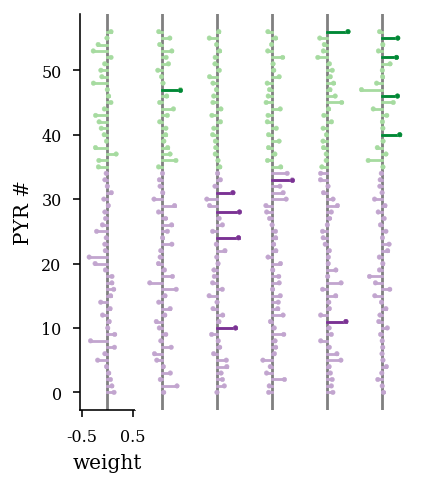

In [549]:
session = 'Z:\\home\\ryanh\\projects\\ripple_heterogeneity\\cell_assembly_v1\\Z__Data_AYAold_AB1_day1.pkl'
with open(session, 'rb') as f:
    results = pickle.load(f)

# first, sort cells by sublayer
sort_idx = np.argsort(results['deepSuperficial'])
results['deepSuperficial'] = results['deepSuperficial'].iloc[sort_idx]

patterns = results['patterns_inside_ripples']
patterns = [pat[sort_idx] for pat in patterns]
patterns = np.array(patterns)

# get colors per sub group
colors = ['#c2a5cf']* results['deepSuperficial'].shape[0]
colors = np.array(colors)
colors[results['deepSuperficial'] == 'Deep'] = ['#c2a5cf']*sum(results['deepSuperficial'] == 'Deep')
colors[results['deepSuperficial'] == 'Superficial'] = ['#a6dba0']*sum(results['deepSuperficial'] == 'Superficial')

colors_sig = ['#7b3294']* results['deepSuperficial'].shape[0]
colors_sig = np.array(colors_sig)
colors_sig[results['deepSuperficial'] == 'Deep'] = ['#7b3294']*sum(results['deepSuperficial'] == 'Deep')
colors_sig[results['deepSuperficial'] == 'Superficial'] = ['#008837']*sum(results['deepSuperficial'] == 'Superficial')


fig, axs = plt.subplots(1,patterns.shape[0], figsize=functions.set_size('thesis', fraction=.5, subplots=(patterns.shape[0], patterns.shape[0]/2)), edgecolor='k')

fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()

for i,assmbl in enumerate(patterns):

    axs[i].scatter(assmbl,np.arange(len(assmbl)),c=colors,zorder=1000,s=5)

    thres = np.mean(assmbl) + np.std(assmbl)*2
    idx = assmbl > thres
    axs[i].scatter(assmbl[idx],np.arange(len(assmbl))[idx],c=colors_sig[idx],zorder=1000,s=5)

    for j,item in enumerate(assmbl):
        axs[i].plot(np.sort([item,0]),[j,j],color=colors[j],zorder=-50)
        if idx[j]:
            axs[i].plot(np.sort([item,0]),[j,j],color=colors_sig[j],zorder=-50)

    axs[i].axvline(0,color='grey',zorder=-100)

    for i in range(patterns.shape[0]):
        axs[i].set_xlim(-patterns.max()-.1,patterns.max()+.1)

    for i in range(patterns.shape[0]):
        axs[i].spines["right"].set_visible(False)
        axs[i].spines["top"].set_visible(False)  

    for i in np.arange(1,patterns.shape[0]):
        axs[i].spines["left"].set_visible(False)  
        axs[i].spines["bottom"].set_visible(False)      
        axs[i].get_yaxis().set_ticks([])
        axs[i].get_xaxis().set_ticks([])

    axs[0].set_ylabel('PYR #')
    axs[0].set_xlabel('weight')
    axs[0].set_xticks([-.5,.5])
    axs[0].set_xticklabels([-.5,.5])

plt.savefig(os.path.join(fig_save_path,'assembly_weight_example.svg'),dpi=300,bbox_inches='tight')


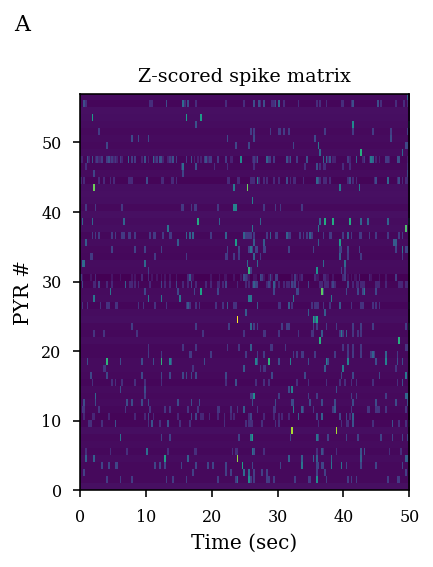

In [430]:
plt.figure(figsize=functions.set_size('thesis', fraction=.5, subplots=(patterns.shape[0], patterns.shape[0]/2)), edgecolor='k')
sort_idx = np.argsort(results['deepSuperficial'])

plt.imshow(results['zactmat_inside_ripples'][sort_idx,2500:2700],aspect='auto',interpolation='nearest',origin='lower',extent=[0,200*.25,0,patterns.shape[1]],vmax=15)
plt.ylabel('PYR #')
plt.xlabel('Time (sec)')
plt.title('Z-scored spike matrix')

axs = plt.gca()
for i, label in enumerate(('A')):
    axs.text(-0.15, 1.2, label, transform=axs.transAxes,
        fontsize=11, fontweight='normal', va='top', ha='right')

plt.savefig(os.path.join(fig_save_path,'assembly_zactmat_example.svg'),dpi=300,bbox_inches='tight')


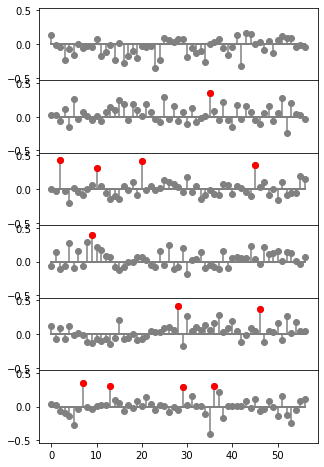

In [124]:
# results['patterns_outside_ripples'].shape
# results['patterns_inside_ripples'].shape
# sns.heatmap(results['patterns_outside_ripples'])
# plt.show()
# sns.heatmap(results['patterns_inside_ripples'])
group_colors = {"deep": '#7b3294',
            "deep_non_member": '#c2a5cf',
            'sup': '#008837',
            'sup_non_member': '#a6dba0'} 

def plot_lolipop(patterns,colors):
    fig, axs = plt.subplots(patterns.shape[0],1, figsize=(5, 8), edgecolor='k')
    fig.subplots_adjust(hspace = 0.00, wspace=0)
    axs = axs.ravel()

    for i,assmbl in enumerate(patterns):
        markerline, stemlines, baseline = axs[i].stem(np.arange(len(assmbl)),assmbl,linefmt='grey')
        markerline.set_markerfacecolor('grey')
        markerline.set_markeredgecolor('grey')
        plt.setp(baseline, color='grey', linewidth=2,zorder=-100)
        thres = np.mean(assmbl) + np.std(assmbl)*2
        idx = assmbl > thres
        axs[i].scatter(np.arange(len(assmbl))[idx],assmbl[idx],color='red',zorder=1000)



    for i in range(patterns.shape[0]):
        axs[i].set_ylim(-patterns.max()-.1,patterns.max()+.1)
        # axs[i].axis('off')

plot_lolipop(results['patterns_inside_ripples'],colors)        
# plot_lolipop(results['patterns_outside_ripples']) 
# plt.gca().invert_yaxis()

In [120]:



# get smooth vector-function containing each neuron's z-scored instantaneous FR
z_t, ts = get_z_t(st)

In [121]:
patterns, significance, zactmat = assembly.runPatterns(binned_st.data)
assemblyAct = assembly.computeAssemblyActivity(patterns, z_t)

In [122]:
assembly_act = nel.AnalogSignalArray(data=assemblyAct,timestamps=ts,fs=1000)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.


<AxesSubplot:>

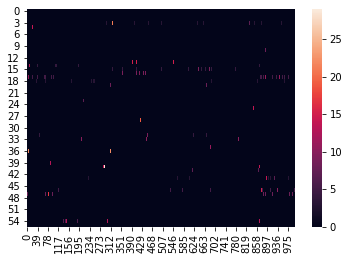

In [123]:
sns.heatmap(zactmat[:,0:1000])

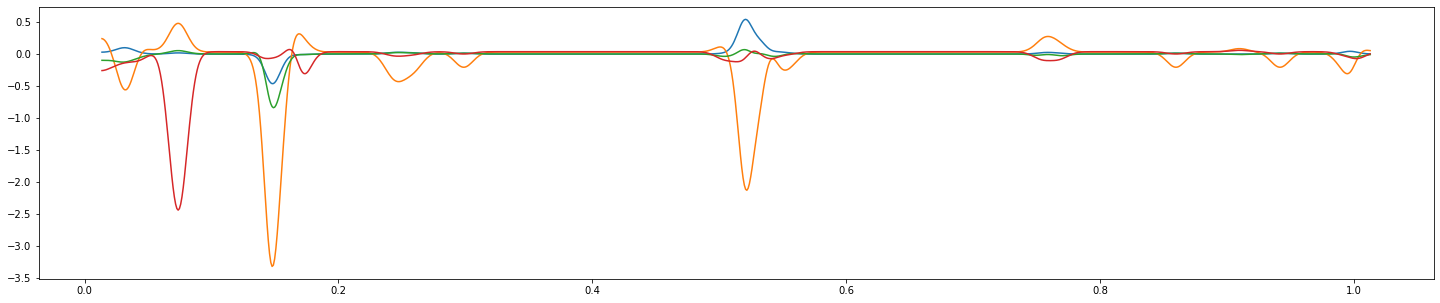

In [124]:
plt.figure(figsize=(25,5))
plt.plot(ts[0:1000],assemblyAct[0,0:1000])
plt.plot(ts[0:1000],assemblyAct[1,0:1000])
plt.plot(ts[0:1000],assemblyAct[2,0:1000])
plt.plot(ts[0:1000],assemblyAct[3,0:1000])
plt.show()

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


AttributeError: 'Line2D' object has no property 'cmap'

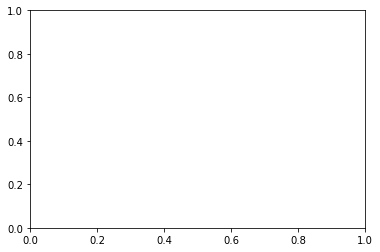

In [58]:
rip_n = 4
cmap = matplotlib.cm.get_cmap('tab20b',patterns.shape[0])

plt.plot(assembly_act[ripple_epochs[rip_n]].abscissa_vals ,assembly_act[ripple_epochs[rip_n]].data.T,cmap=cmap)
plt.show()
# plt.eventplot(st[ripple_epochs[4]].data)
# plt.show()

import matplotlib


thres = patterns.mean(axis=1) + patterns.std(axis=1)
temp_pattens = patterns.copy()
temp_pattens[patterns <  thres[:,np.newaxis]] = 0
assmbl_unit_id = temp_pattens.argmax(axis=0)

axs = plt.gca()
color_idx = 0
for i,unit_id in enumerate(pd.unique(assmbl_unit_id)):
    npl.rasterplot(st[ripple_epochs[rip_n]][:,np.where(assmbl_unit_id == unit_id)[0]+1],color=cmap(color_idx), lw=2, lh=1, ax=axs, vertstack=True)
    axs.plot(assembly_act[ripple_epochs[rip_n]].abscissa_vals,assembly_act[ripple_epochs[rip_n]].data[unit_id,:]+10*i, color=cmap(color_idx),linewidth=.75,zorder=1000-i,alpha=1)
    color_idx+=1

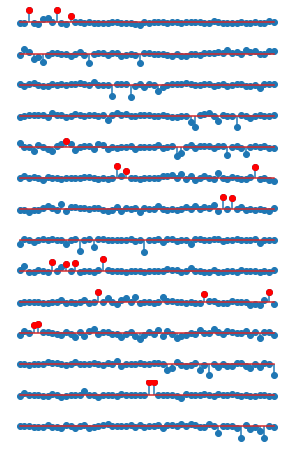

In [125]:
fig, axs = plt.subplots(patterns.shape[0],1, figsize=(5, 8), edgecolor='k')
fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()

for i,assmbl in enumerate(patterns):
    axs[i].stem(np.arange(len(assmbl)),assmbl)
    thres = np.mean(assmbl) + np.std(assmbl)*2
    idx = assmbl > thres
    axs[i].scatter(np.arange(len(assmbl))[idx],assmbl[idx],color='red',zorder=1000)
    
for i in range(patterns.shape[0]):
    axs[i].set_ylim(-patterns.max()-.1,patterns.max()+.1)
    axs[i].axis('off')

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


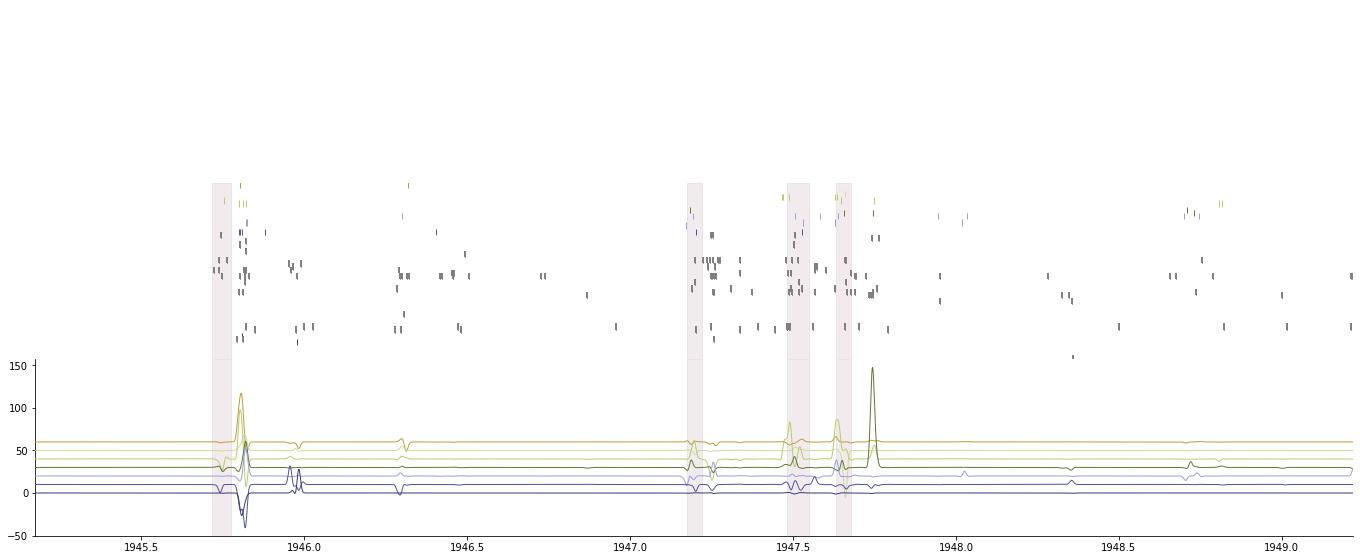

In [136]:
def plot_assembl_strength(st,patterns,assembly_act,interval,axs,show_not_in_assmbl=True,vertstack=True):
    
    cmap = matplotlib.cm.get_cmap('tab20b',patterns.shape[0])

    interval = nel.EpochArray(interval)
    st = st[interval]

    assembly_act = assembly_act[interval]
    
    thres = patterns.mean(axis=1) + patterns.std(axis=1)*2
    temp_pattens = patterns.copy()
    temp_pattens[patterns <  thres[:,np.newaxis]] = 0
    assmbl_unit_id = temp_pattens.argmax(axis=0)
    
    color_idx = 0
    for i,unit_id in enumerate(pd.unique(assmbl_unit_id)):
        npl.rasterplot(st[:,np.where(assmbl_unit_id == unit_id)[0]+1],color=cmap(color_idx), lw=1, lh=2, ax=axs[1], vertstack=vertstack)
        axs[2].plot(assembly_act.abscissa_vals,assembly_act.data[unit_id,:]+10*i, color=cmap(color_idx),linewidth=1,zorder=1000-i,alpha=1,label='assembly:'+str(unit_id))
        color_idx+=1
        
    npl.rasterplot(st[:,np.where(temp_pattens.max(axis=0) == 0)[0]+1],color='grey', lw=2, lh=2, ax=axs[1], vertstack=True)

    axs[1].set_xlim(interval.data[0][0],interval.data[0][1])
    axs[2].set_xlim(interval.data[0][0],interval.data[0][1])
    axs[1].axis('off')
    axs[2].spines["right"].set_visible(False)
    axs[2].spines["top"].set_visible(False)

fig, axs = plt.subplots(3,1, figsize=functions.set_size('thesis', fraction=4, subplots=(2, 3)), edgecolor='k')
fig.subplots_adjust(hspace = 0, wspace=0)
axs = axs.ravel()  

rip_n = 201
interval = [ripple_epochs[rip_n].start-2, ripple_epochs[rip_n].stop+2]

plot_assembl_strength(st,patterns,assembly_act,interval,axs,show_not_in_assmbl=False,vertstack=True)

axs[0].axis('off')

for item in ripples[ripples['peaks'].between(interval[0], interval[1])].itertuples():
    axs[1].axvspan(item.start, item.stop, alpha=0.1, color='#843b62', zorder=-2000)
    axs[2].axvspan(item.start, item.stop, alpha=0.1, color='#843b62', zorder=-2000)

# axs[2].legend()

In [ ]:
assembl_strength = []
assembl_frac = []

for ripple in ripples.itertuples():
    # pull out current assembly based on ripple width
    curr_assembl = assemblyAct[:,(ts >= ripple.start_time) & (ts <= ripple.end_time)]
    # Assembly strength during SPW-R periods
    assembl_strength.append(np.median(curr_assembl.max(axis=0)[curr_assembl.max(axis=0) > 5]))
    
    # fraction of active assemblies active during SPW-R 
    assembl_frac.append(sum(np.any(curr_assembl > 5,axis=1)) / curr_assembl.shape[0])

n_assembl = (patterns.shape[0])
n_units = (patterns.shape[1])
n_assembl_n_cell_frac = (patterns.shape[0]/patterns.shape[1])    

# number of cells that contribute significantly (>2 SD) to each assembly     
n_cells_per_assembl_ = np.sum(patterns > (patterns.mean(axis=1) + patterns.std(axis=1)*2)[:, np.newaxis],axis=1)
n_cells_per_assembl = (n_cells_per_assembl_[n_cells_per_assembl_ > 0].mean())  